## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# Подготовка 1

In [1]:
! pip install statsmodels

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

In [3]:
class DataScience:

    def rmse(self,predictions, targets): 
        return np.sqrt(((predictions - targets) ** 2).mean())
    
    
    def plot_feature_importance(self,importance,names,model_type):

        feature_importance = np.array(importance)
        feature_names = np.array(names)

        #Create a DataFrame using a Dictionary
        data={'feature_names':feature_names,'feature_importance':feature_importance}
        fi_df = pd.DataFrame(data)

        #Sort the DataFrame in order decreasing feature importance
        fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

        #Define size of bar plot
        plt.figure(figsize=(10,8))
        #Plot Searborn bar chart
        sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
        #Add chart labels
        plt.title(model_type + 'FEATURE IMPORTANCE')
        plt.xlabel('FEATURE IMPORTANCE')
        plt.ylabel('FEATURE NAMES')
        
        
ds = DataScience()

Загрузим и посмотрим на данные.

In [4]:
#df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

def info(df)

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
# Взглянем на пропуски 
df.isna().mean()

num_orders    0.0
dtype: float64

In [7]:
#Проверим упорядочен ли наш index
print(df.index.is_monotonic)

True


# Анализ

In [8]:
# Проведем ресемплирование по 1 часу, неделе и месяцу
monthly_stat= df.resample('1M').sum()
weekly_stat = df.resample('1W').sum()
hourly_stat = df.resample('1H').sum()

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

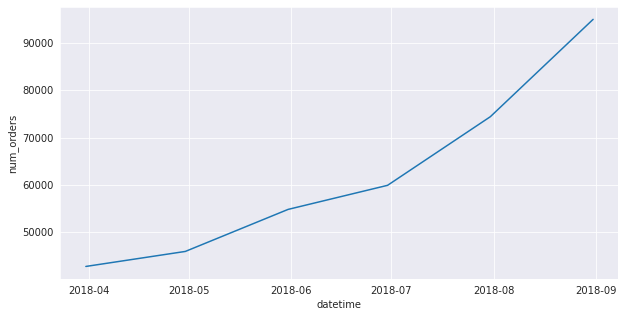

In [9]:
#Посмотрим на статистику заказов в разбивке по месяцам
sns.lineplot(x=monthly_stat.index,y=monthly_stat['num_orders'])

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

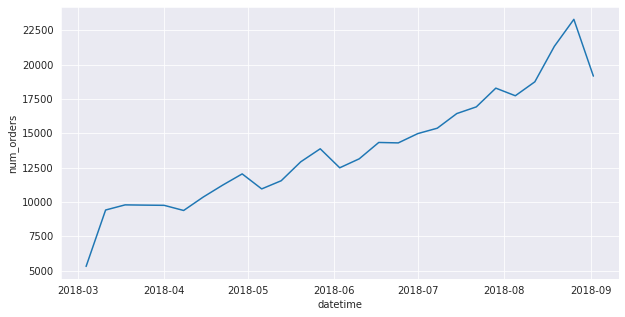

In [10]:
sns.lineplot(x=weekly_stat.index, y=weekly_stat['num_orders'])

<AxesSubplot:xlabel='datetime'>

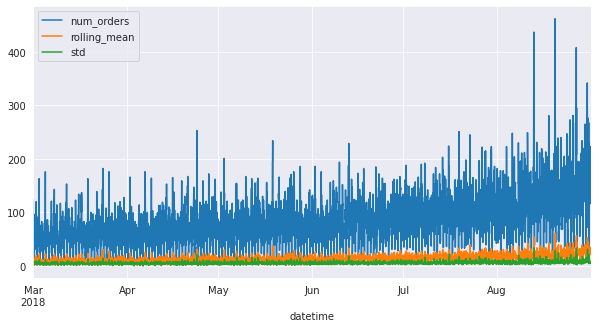

In [11]:
hourly_stat['rolling_mean'] = df.rolling(10).mean()
hourly_stat['std'] = df['num_orders'].rolling(10).std()
hourly_stat.plot()

In [12]:
#Сделаем копию датасета чтобы провести анализ
df_copy = df.copy()
df_copy = df_copy.resample('1H').sum()
df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(12).mean()
df_copy['std'] = df_copy['num_orders'].rolling(12).std()
df_copy = df_copy.dropna()

In [13]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [14]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [15]:
df_copy = df.copy()
df_copy = df_copy.resample('1H').sum()
df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(12).mean()
df_copy['std'] = df_copy['num_orders'].rolling(12).std()
df_copy = df_copy.dropna()

In [16]:
df_copy['num_orders'] = df_copy['num_orders'].astype('float')

<Figure size 1080x288 with 0 Axes>

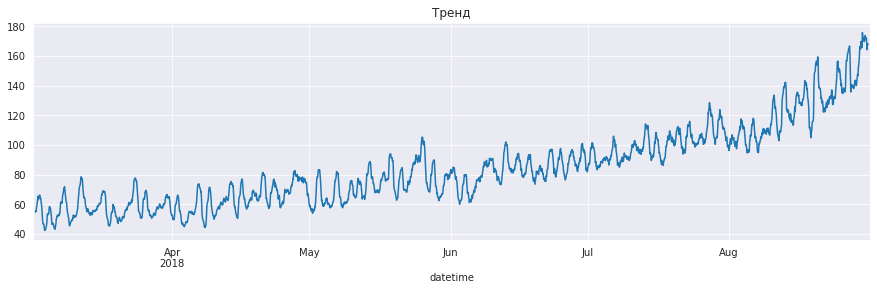

<Figure size 1080x288 with 0 Axes>

In [17]:
decomposed_df = seasonal_decompose(df_copy['num_orders'])
decomposed_df.trend.plot(title='Тренд', figsize=(15,4))
plt.figure(figsize=(15, 4))


<AxesSubplot:title={'center':'Сезонность'}, xlabel='datetime'>

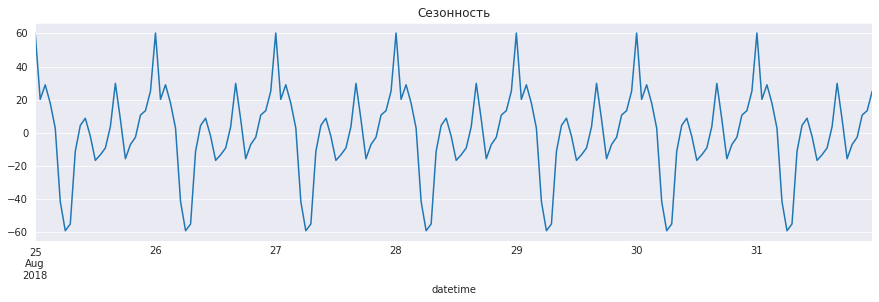

In [18]:
decomposed_df.seasonal.tail(24*7).plot(title='Сезонность', figsize=(15,4))

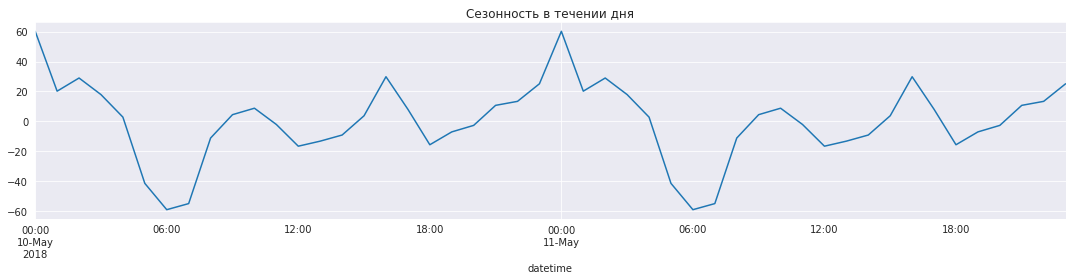

In [19]:
decomposed_df.seasonal['2018-05-10':'2018-05-11'].plot(ax=plt.gca(), figsize=(15,4))
plt.title('Сезонность в течении дня')
plt.tight_layout()

**Вывод:**
- На графике "Тренд" можно увидеть, что количество заказов постепенно увеличивается.
- На графике сезонность разбитое на неделю видно, как количество заказов по выходным меньше чем в другие дни
- На третьем графике количество заказов к утру намного меньше, чем в другое время
 

# Обучение.

In [20]:
#выполним ресемплирование по одному часу
df = df.resample('1H').sum()

#Создадим признаки
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 9, 9)

In [21]:
#Разделим нашу таблилцу на обучающую и тестовую выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [22]:
#Определим признаки и целевой признак у обучающей и тестовой выборк
X = train.drop(['num_orders'], axis=1)
y = train['num_orders']
X_test = test.drop(['num_orders'],axis=1)
y_test = test['num_orders']

In [23]:
#Проверим правильно ли расположены временные даннные, нельзя допустить в обучающую выборку данные из будущего
display(train.tail(3))
display(test.head(3))

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,,
2018-08-13 11:00:00,144,0,11,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,146.666667
2018-08-13 12:00:00,92,0,12,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,114.111111
2018-08-13 13:00:00,119,0,13,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,105.666667


,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,,
2018-08-13 14:00:00,102,0,14,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,103.000000
2018-08-13 15:00:00,175,0,15,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,105.111111
2018-08-13 16:00:00,144,0,16,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,117.222222


In [24]:
#Размеры обучающей и тестовой выборки
print('Размер обучающей выборки: {} объектов, {} признаков'.format(X.shape[0], X.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(X_test.shape[0], X_test.shape[1]))

Размер обучающей выборки: 3965 объектов, 12 признаков
Размер тестовой выборки: 442 объектов, 12 признаков


In [25]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X,y)
lr_predictions = lr.predict(X_test)
print('RMSE:', ds.rmse(lr_predictions,y_test))

RMSE: 54.087584347574904


In [ ]:
#Попробуем подобрать параметры с помощью цикла
estimators = [50,100,200,300]
forleaves = [2,5,7,12]


for estim, leaves in zip(estimators, forleaves):
    lgb_model = lgb.LGBMRegressor(n_estimators=estim, num_leaves=leaves)
    lgb_model.fit(X,y)
    predictions = lgb_model.predict(X)
    print('RMSE with n_estimators : {} and num_leaves: {} is {}'.format(estim, leaves, ds.rmse(predictions, y)))

LightGBM показал лучший результат на обучающей выборке с ним и будем работать дальше

In [27]:
model = lgb.LGBMRegressor(
                          n_estimators=300,
                          num_leaves=12,
                          objective='regression'
)

model.fit(X,y)
predictions = model.predict(X_test)
print('RMSE на тестовой выборке:', ds.rmse(predictions,y_test))

RMSE на тестовой выборке: 43.92340606427539


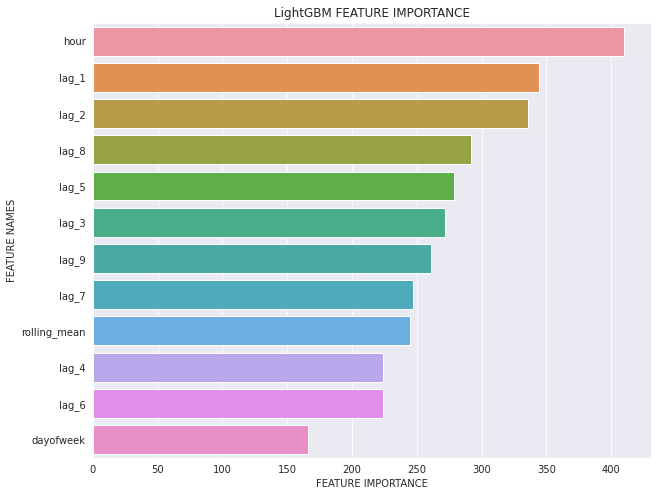

In [28]:
#Посмотрим feature importance у модели lightgbm
ds.plot_feature_importance(model.feature_importances_,X_test.columns,'LightGBM ')

<AxesSubplot:xlabel='datetime'>

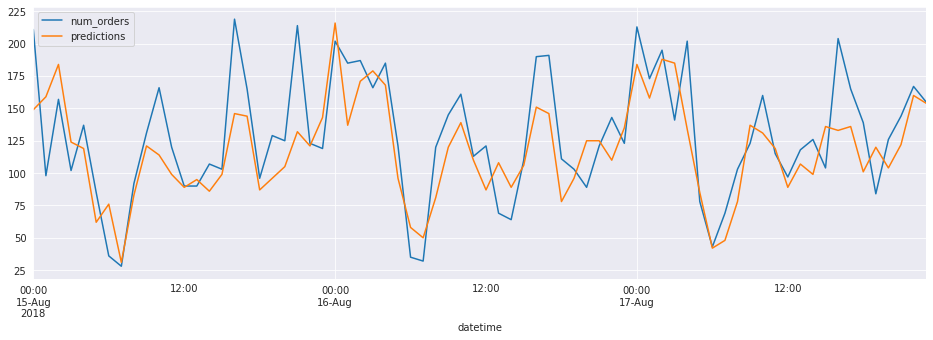

In [29]:
#выведем на графике реальное количество заказов в день и предсказанное нашей моделью. 
graph = y_test.copy()
predictions_taxi = pd.DataFrame(data = predictions, columns = ['predictions'], index = X_test.index.copy())
df_out = pd.merge(graph, predictions_taxi, how = 'left', left_index = True, right_index = True)
df_out['predictions'] = df_out['predictions'].astype('int64')
df_out['2018-08-15':'2018-08-17'].plot(figsize=(16,5))

## Вывод:

Как видно по графику, наша модель достаточно хорошо попадает в реальные заказы. Конечно есть плюс-минус погрешности, которые можно исправить, если хорошо подтюнить модель. Но в целом, считаю, что довольно-таки неплохой результат :) 